## DETR: inference notebook

In this notebook, we are going to run the [DETR](https://arxiv.org/abs/2005.12872) model by Facebook AI (which is part of 🤗 Transformers) to perform table detection and table structure recognition on documents.

### Quick intro: DETR
DETR is short for DEtection TRansformer, and consists of a convolutional backbone (ResNet-50 or ResNet-101) followed by an encoder-decoder Transformer. It can be trained end-to-end to perform object detection (and panoptic segmentation, for that see my other notebooks in my repo [Transformers-tutorials](https://github.com/NielsRogge/Transformers-Tutorials)).The main contribution of DETR is its simplicity: compared to other models like Faster R-CNN and Mask R-CNN, which rely on several highly engineered things like region proposals, non-maximum suppression procedure and anchor generation, DETR is a model that can simply be trained end-to-end, and fine-tuned just like you would fine-tune BERT. This is possible due to the use of a clever loss function, the so-called **bipartite matching loss**. I highly recommend [Yannic Kilcher's video](https://www.youtube.com/watch?v=T35ba_VXkMY&t=1693s) if you want to understand how the full model works.

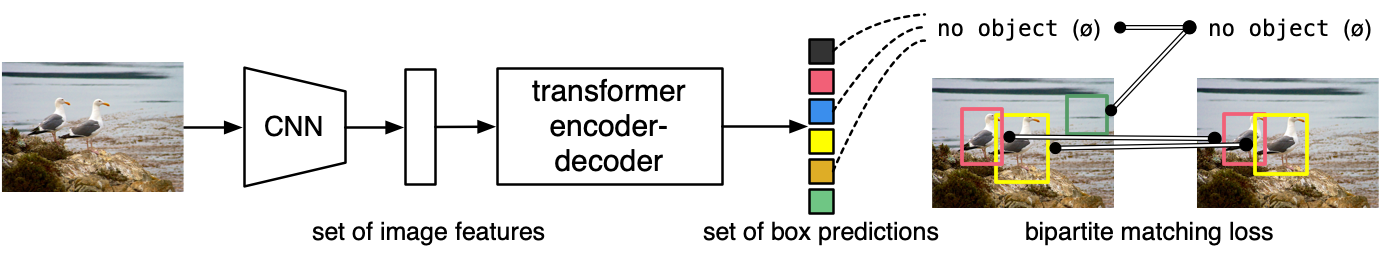

* Paper: https://arxiv.org/abs/2005.12872
* Blog post: https://ai.facebook.com/blog/end-to-end-object-detection-with-transformers/
* Official Github repository: https://github.com/facebookresearch/detr

I converted all DETR checkpoints to their HuggingFace version. I'm using Ross Wightman's awesome [timm library](https://github.com/rwightman/pytorch-image-models/) to support any convolutional backbone rather than just ResNet-50 and ResNet-101, which were used in the original paper. You can see all available checkpoints on the [hub](https://huggingface.co/models?search=facebook/detr).

Also note that this notebook is just the HuggingFace version of the [official demo notebook](https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb). All credits go to the original authors for creating this awesome model.

My other DETR notebooks (which showcase how you can fine-tune DETR on a custom dataset, both for object detection and panoptic segmentation) can be found [here](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/DETR).


In [1]:
!rm -r transformers
!git clone -b add_table_transformer https://github.com/nielsrogge/transformers.git
!cd transformers
!pip install -q ./transformers

"rm" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
fatal: destination path 'transformers' already exists and is not an empty directory.
ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\tigra\\PycharmProjects\\OcrResearch\\venv_ocr_python\\Lib\\site-packages\\~-kenizers\\tokenizers.cp310-win_amd64.pyd'
Check the permissions.

You should consider upgrading via the 'C:\Users\tigra\PycharmProjects\OcrResearch\venv_ocr_python\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip install -q timm

You should consider upgrading via the 'C:\Users\tigra\PycharmProjects\OcrResearch\venv_ocr_python\Scripts\python.exe -m pip install --upgrade pip' command.


## Table detection

Table detection is the task of - you guessed it - detect tables in document images, like PDFs.

Let's load a PDF and see how our model does.

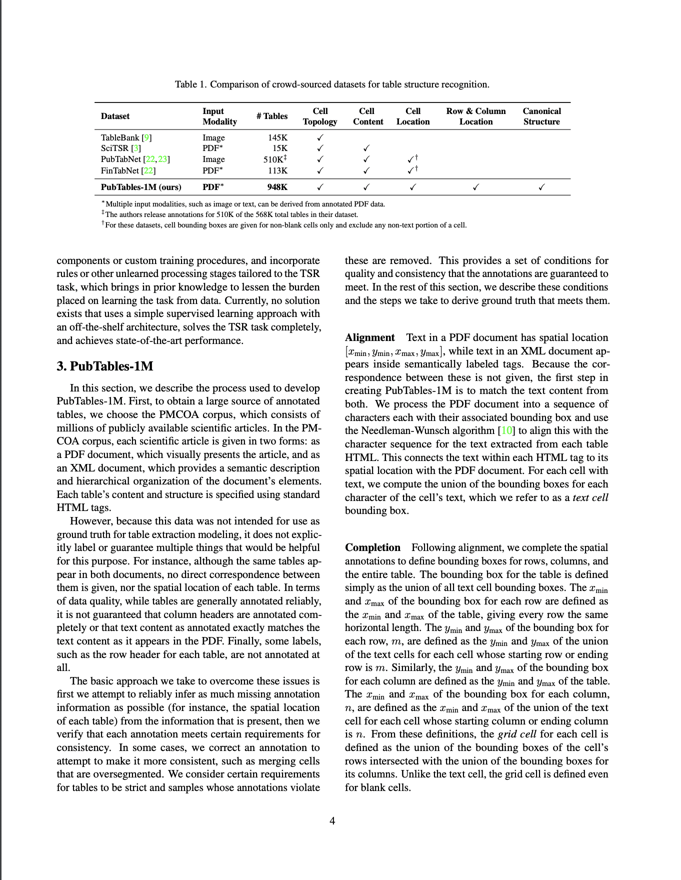

In [3]:
from huggingface_hub import hf_hub_download
from PIL import Image

file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="example_pdf.png")
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

Let's first apply the regular image preprocessing using `DetrFeatureExtractor`. The feature extractor will resize the image (minimum size = 800, max size = 1333), and normalize it across the channels using the ImageNet mean and standard deviation.

In [4]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor()
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

ImportError: tokenizers>=0.14,<0.15 is required for a normal functioning of this module, but found tokenizers==0.12.1.
Try: pip install transformers -U or pip install -e '.[dev]' if you're working with git main

In [ ]:
print(encoding['pixel_values'].shape)

torch.Size([1, 3, 1033, 800])


## Forward pass

Next, let's send the pixel values and pixel mask through the model. We first load the model from the hub, and perform a forward pass.

In [ ]:
from transformers import DetrForObjectDetection

model = DetrForObjectDetection.from_pretrained("nielsr/detr-table-detection")

In [ ]:
import torch

with torch.no_grad():
  outputs = model(**encoding)

Let's visualize the results!

In [ ]:
import matplotlib.pyplot as plt

# colors for visualization
colors = ["red", "blue", "green", "yellow", "orange", "violet"]

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(32,20))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        cl = p.argmax()
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=colors[cl.item()], linewidth=3))
        text = f'{model.config.id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
import torch

# keep only predictions of queries with 0.9+ confidence (excluding no-object class)
probas = outputs.logits.softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# rescale bounding boxes
target_sizes = torch.tensor(image.size[::-1]).unsqueeze(0)
postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
bboxes_scaled = postprocessed_outputs[0]['boxes'][keep]

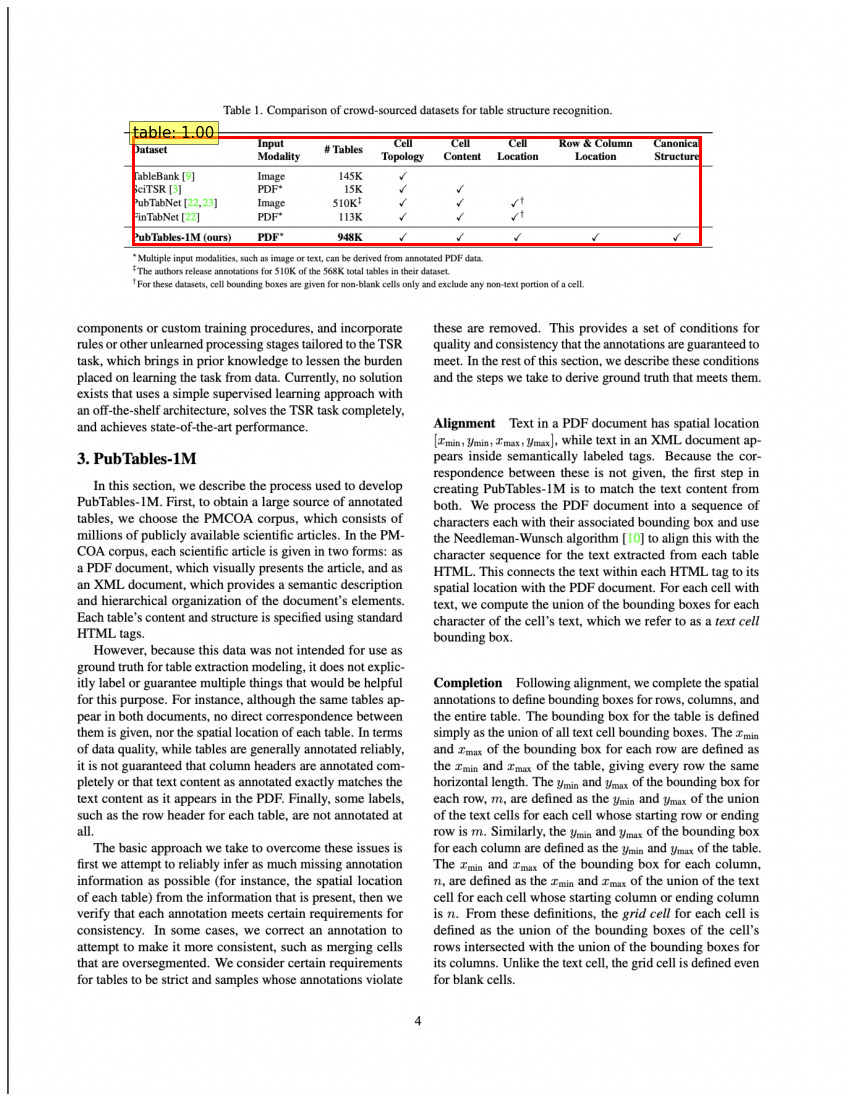

In [ ]:
plot_results(image, probas[keep], bboxes_scaled)

Cool! Seems like our model has correctly identified the single table present in the PDF.

## Table structure recognition

Table structure recognition is the task of identifying the several rows, columns, cells in a table.

Let's load a demo table (which I took from the [paper](https://openaccess.thecvf.com/content/CVPR2022/html/Smock_PubTables-1M_Towards_Comprehensive_Table_Extraction_From_Unstructured_Documents_CVPR_2022_paper.html)) and see how our model does.

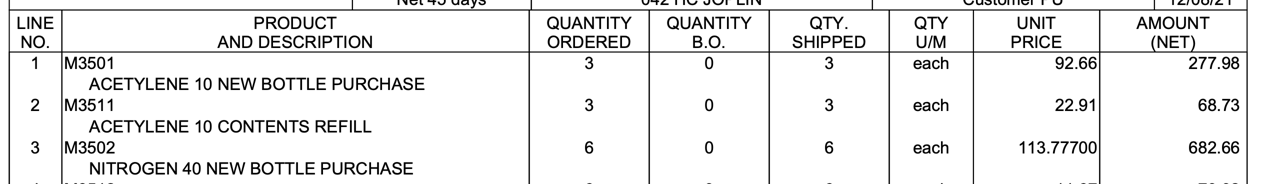

In [ ]:
from huggingface_hub import hf_hub_download
from PIL import Image

file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="example_table.png")
image = Image.open(file_path).convert("RGB")
image = Image.open("/content/Screen Shot 2022-09-06 at 8.09.35 AM (1).png").convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

Let's prepare the image for the model using `DetrFeatureExtractor`.

In [ ]:
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

dict_keys(['pixel_values', 'pixel_mask'])

Let's load the model from the hub, and perform a forward pass.

In [ ]:
from transformers import DetrForObjectDetection

model = DetrForObjectDetection.from_pretrained("nielsr/detr-table-structure-recognition")

In [ ]:
with torch.no_grad():
  outputs = model(**encoding)

Let's visualize the results!

In [ ]:
import matplotlib.pyplot as plt

# colors for visualization
colors = ["red", "blue", "green", "yellow", "orange", "violet"]

def plot_results(pil_img, prob, boxes, class_to_show=0):
    plt.figure(figsize=(32,20))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        cl = p.argmax()
        if cl.item() == class_to_show:
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=colors[cl.item()], linewidth=3))
          text = f'{model.config.id2label[cl.item()]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
        else:
          continue
    plt.axis('off')
    plt.show()

In [ ]:
import torch

# keep only predictions of queries with 0.9+ confidence (excluding no-object class)
probas = outputs.logits.softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.6

# rescale bounding boxes
target_sizes = torch.tensor(image.size[::-1]).unsqueeze(0)
postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
bboxes_scaled = postprocessed_outputs[0]['boxes'][keep]

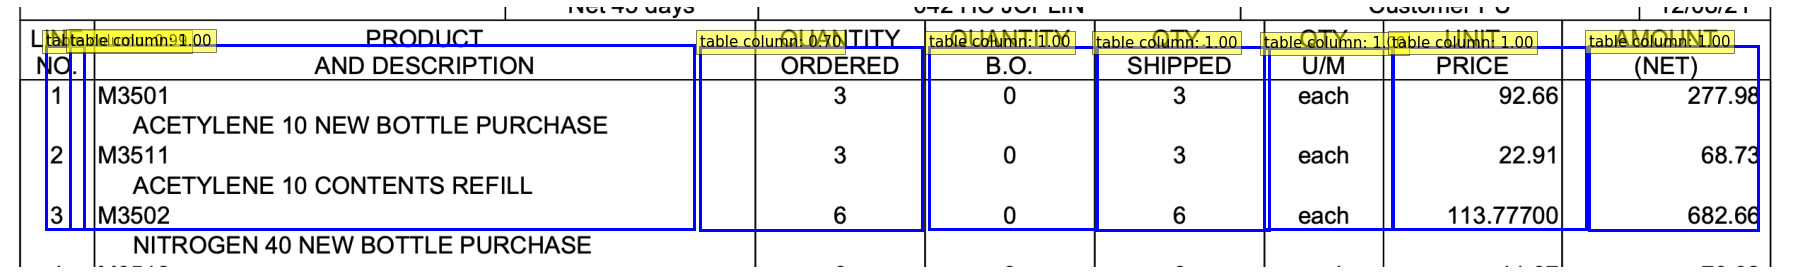

In [ ]:
plot_results(image, probas[keep], bboxes_scaled, class_to_show=1)

In [ ]:
model.config.id2label

{0: 'table',
 1: 'table column',
 2: 'table row',
 3: 'table column header',
 4: 'table projected row header',
 5: 'table spanning cell'}